# Main Analysis

This file does not rely on user input. So we would like to keep it interchangeable with the actual main_analysis.py file.
So please keep all the >relevant< code within one code block. (If you want to inspect certain elements or do other things that are not relevant to the main analysis, you can of course add them in new blocks).

In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import mne
from autoreject import AutoReject

from data_analysis.functions_preprocessing import \
    (combine_raws, split_raws, preprocess_single_sub, mark_bads_and_save,
     run_ica_and_save)
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)
from data_analysis.functions_connectivity import \
    full_ispc
from data_analysis.functions_graph_theory import \
    weighted_small_world_coeff


subject_dir = "/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"



# Main Data Analysis ###################################
# initialize containers to analyze later
connectivity_matrices = []
small_world_coeffs = []

# Perform the data analysis
for subj_pair in ['202']:  #['202','203','204','205','206','207','208','209','211','212']:

    subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj_pair)
    behav_path = op.join(behav_dir, "{0}.csv".format(subj_pair))

    combined_raw = mne.io.read_raw_fif(subs_path, preload=True)

    # split the subjects and delete the raw file
    raws = split_raws(combined_raw)
    del combined_raw

    # apply the preprocessing
    for idx, raw in enumerate(raws):
        #subj_idx = "sub-{0}_p-{1}".format(subj_pair, idx)
        # set the EEG reference. We use Cz as a reference
        raw.set_eeg_reference(["Cz"])

        # set the EEG Montage. We use 64 chans from the standard 10-05 system.
        montage = mne.channels.make_standard_montage("standard_1005")
        raw.set_montage(montage)
        
        # Apply high pass/low pass filter
        raw.filter(l_freq = 0.1, h_freq = 120) # using firwin
        raw.notch_filter(freqs=[16.666666667, 50])  # bandstop train and AC
        
        # Do the surface laplacian
        raw = mne.preprocessing.compute_current_source_density(raw)


    # combine the subjects again
    raw_combined = combine_raws(raws[0], raws[1])
    del raws  # to save memory

    # do the behavioral analysis and get the epochs
    behavioral_df = calculate_alpha(pd.read_csv(behav_path))
    
    event_df = create_event_df(raw_combined)
    event_df = remove_ghost_triggers(event_df)
    event_df = join_event_dfs(event_df, behavioral_df)
    event_df = remove_outliers(event_df, exclude_stddev=2)
    events = events_from_event_df(event_df)

    # define the parameters for epoching
    # TODO: Define events more elaborate!
    event_id = 11
    tmin = 0
    tmax = 3
    

    # epoch the data. Here we filter out bad segments from both participants
    # TODO: do we need a baseline for the connectivity analysis?
    epochs = mne.Epochs(raw_combined, events, event_id, tmin, tmax,
                        picks=["eeg"], baseline=(0, 0), preload=True)
    
    ars = []
    for sub in range(2):

        picks = mne.pick_channels(epochs.ch_names, include=[chan for chan in epochs.ch_names if "sub" + str(sub + 1) in chan])

        # autoreject
        ar = AutoReject(consensus=np.linspace(0, .5, 6), thresh_method='random_search', verbose="tqdm_notebook",
                        picks=picks)

        # Note that fitting and transforming can be done on different compatible
        # portions of data if needed.
        ar.fit(epochs)
        #epochs_clean = ar.transform(epochs)


        #len(epochs_clean)
        ar.get_reject_log(epochs).plot()
        ars.append(ar)
        
    


    # Perform the high level analysis for each epoch
    for epoch in epochs[:1]:

        # calculate the ISPC
        ispc_matrix, freqs = full_ispc(epoch, epochs.info["sfreq"],
                                       nperseg=32)

        # calculate the small world coefficient for each frequency
        small_worlds = [weighted_small_world_coeff(ispc_matrix[:, :, i].squeeze())
                        for i in range(ispc_matrix.shape[2])]

        # append the results to the respective lists
        connectivity_matrices.append(ispc_matrix)
        small_world_coeffs.append(small_worlds)

Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif...



Bad key "text.kerning_factor" on line 4 in
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
<ipython-input-1-3f6ac02aa522>:39: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 5675445  =      0.000 ...  5542.427 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 337

RuntimeError: Since bad epochs have not been dropped, the length of the Epochs is not known. Load the Epochs with preload=True, or call Epochs.drop_bad(). To find the number of events in the Epochs, use len(Epochs.events).

288 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 288 events and 3073 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg








Estimated consensus=0.20 and n_interpolate=4


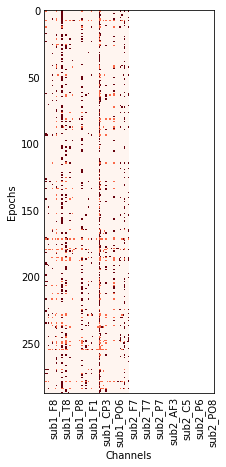

Running autoreject on ch_type=eeg








Estimated consensus=0.20 and n_interpolate=4


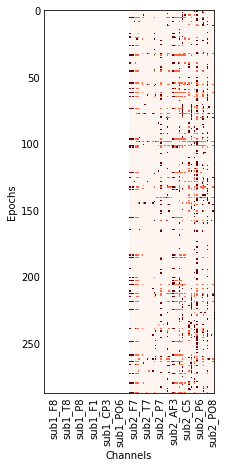

In [50]:


# epoch the data. Here we filter out bad segments from both participants
# TODO: do we need a baseline for the connectivity analysis?
epochs = mne.Epochs(raw_combined, events, event_id, tmin, tmax,
                    picks=["eeg"], baseline=(0, 0), preload=True)

#
#print("Length of epochs before AR: ", len(epochs))
ars = []
for sub in range(2):
    
    picks = mne.pick_channels(epochs.ch_names, include=[chan for chan in epochs.ch_names if "sub" + str(sub + 1) in chan])
    
    # autoreject
    ar = AutoReject(consensus=np.linspace(0, .5, 6), thresh_method='random_search', verbose="tqdm_notebook",
                    picks=picks)

    # Note that fitting and transforming can be done on different compatible
    # portions of data if needed.
    ar.fit(epochs)
    #epochs_clean = ar.transform(epochs)


    #len(epochs_clean)
    ar.get_reject_log(epochs).plot()
    ars.append(ar)

In [51]:
# get number of bad_epochs
combined_epochs = np.logical_or(ars[0].get_reject_log(epochs).bad_epochs, ars[1].get_reject_log(epochs).bad_epochs)

In [52]:
sum(combined_epochs)

43

In [48]:
combined_epochs

array([False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
        True, False,